# Predict Next Purchase

In this example, we build a machine learning application to predict whether customers will purchase a product within the next shopping period. This application is structured into three important steps:

* Prediction Engineering
* Feature Engineering
* Machine Learning

In the first step, we generate new labels from the data by using [Compose](https://compose.alteryx.com/). In the second step, we generate features for the labels by using [Featuretools](https://docs.featuretools.com/). In the third step, we search for the best machine learning pipeline by using [EvalML](https://evalml.alteryx.com/). After working through these steps, you will learn how to build machine learning applications for real-world problems like predicting consumer spending. Let's get started.

In [1]:
from demo.next_purchase import load_sample
from matplotlib.pyplot import subplots
import composeml as cp
import featuretools as ft
import evalml

2020-09-04 17:08:15,060 featuretools - WARNING    Featuretools failed to load plugin autonormalize from library autonormalize. For a full stack trace, set logging to debug.
2020-09-04 17:08:15,124 featuretools - WARNING    Featuretools failed to load plugin tsfresh from library featuretools_tsfresh_primitives.__init__. For a full stack trace, set logging to debug.
2020-09-04 17:08:15,194 featuretools - WARNING    Featuretools failed to load plugin nlp_primitives from library nlp_primitives. For a full stack trace, set logging to debug.


We will use this historical data of online grocery orders provided by [Instacart](https://www.kaggle.com/c/instacart-market-basket-analysis/data).

In [2]:
df = load_sample()
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,user_id,order_time
id,,,,,,,,,,
0,120,33120,13,0,Organic Egg Whites,86,16,dairy eggs,23750,2015-01-11 08:00:00
1,120,31323,7,0,Light Wisconsin String Cheese,21,16,dairy eggs,23750,2015-01-11 08:00:00
2,120,1503,8,0,Low Fat Cottage Cheese,108,16,dairy eggs,23750,2015-01-11 08:00:00
3,120,28156,11,0,Total 0% Nonfat Plain Greek Yogurt,120,16,dairy eggs,23750,2015-01-11 08:00:00
4,120,41273,4,0,Broccoli Florets,123,4,produce,23750,2015-01-11 08:00:00


## Prediction Engineering

> Will customers purchase a product within the next shopping period?

In this prediction problem, we have two parameters:

* The product that a customer can purchase.
* The length of the shopping period.

We can change these parameters to create different prediction problems. For example, will a customer purchase a banana within the next 3 days or an avocado within the next three weeks? These variations can be done by simply tweaking the parameters. This helps us explore different scenarios which is crucial for making better decisions.


### Defining the Labeling Function

Let's start by defining a labeling function that checks if a customer bought a given product. We will make the product a parameter of the function. Our labeling function will be used by a label maker to extract the training examples.

In [3]:
def bought_product(ds, product_name):
    return ds.product_name.str.contains(product_name).any()

### Representing the Prediction Problem

Then, let's represent the prediction problem by creating a label maker with the following parameters:

* `target_entity` as the columns for the customer ID, since we want to process orders for each customer.
* `labeling_function` as the function we defined previously.
* `time_index` as the column for the order time. The shoppings periods are based on this time index.
* `window_size` as the length of a shopping period. We can easily change this parameter to create variations of the prediction problem.

In [4]:
lm = cp.LabelMaker(
    target_entity='user_id',
    time_index='order_time',
    labeling_function=bought_product,
    window_size='3d',
)

### Finding the Training Examples

Now, let's run a search to get the training examples by using the following parameters:

* The grocery orders sorted by the order time, since the search will expect the orders to be sorted chronologically, otherwise an error will be raised.
* `num_examples_per_instance` to find the number of training examples per customer. In this case, the search will return all existing examples.
* `product_name` as the product to check for purchases. This parameter gets passed directly to the our labeling function.
* `minimum_data` as the amount of data that will be used to make features for the first training example.

In [5]:
lt = lm.search(
    df.sort_values('order_time'),
    num_examples_per_instance=-1,
    product_name='Banana',
    minimum_data='3d',
    verbose=False,
)

lt.head()

,user_id,time,bought_product
0,2555,2015-01-22 09:00:00,False
1,3283,2015-01-08 13:00:00,True
2,5360,2015-01-21 11:00:00,False
3,5669,2015-01-09 08:00:00,False
4,5669,2015-01-12 08:00:00,True


The output from the search is a label times table with three columns:

* The customer ID associated to the orders. There can be many training examples generated from each customer.
* The start time of the shopping period. This is also the cutoff time for building features. Only data that existed beforehand is valid to use for predictions.
* Whether the product was purchased during the shopping period window. This is calculated by our labeling function.

As a helpul reference, we can print out the search settings that were used to generate these labels. The description also shows us the label distribution which we can check for imbalanced labels.

In [6]:
lt.describe()

Label Distribution
------------------
False     24
True      16
Total:    40


Settings
--------
gap                                    None
minimum_data                             3d
num_examples_per_instance                -1
target_column                bought_product
target_entity                       user_id
target_type                        discrete
window_size                              3d


Transforms
----------
No transforms applied



We can also get a better look at the labels by plotting the distribution and cumulative count across time.

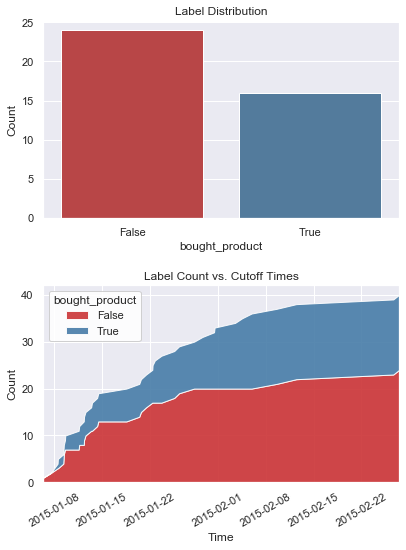

In [7]:
%matplotlib inline
fig, ax = subplots(nrows=2, ncols=1, figsize=(6, 8))
lt.plot.distribution(ax=ax[0])
lt.plot.count_by_time(ax=ax[1])
fig.tight_layout(pad=2)

## Feature Engineering

In the previous step, we generated the labels. The next step is to generate the features.

### Representing the Data

Let's start by representing the data with an entity set. This way, we can generate features based on the relational structure of the dataset. We currently have a single table of orders where one customer can have many orders. This one-to-many relationship can be represented by normalizing a customer entity. The same can be done for other one-to-many relationships like aisle-to-products. We want to make predictions based on the customer, so we will use this customer entity as the target entity for generating features.

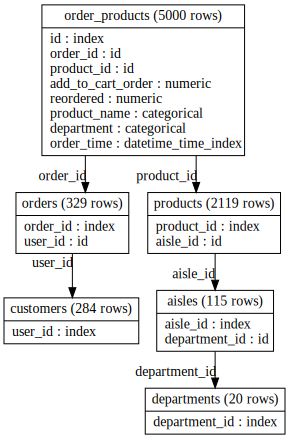

In [8]:
es = ft.EntitySet('instacart')

es.entity_from_dataframe(
    dataframe=df.reset_index(),
    entity_id='order_products',
    time_index='order_time',
    index='id',
)

es.normalize_entity(
    base_entity_id='order_products',
    new_entity_id='orders',
    index='order_id',
    additional_variables=['user_id'],
    make_time_index=False,
)

es.normalize_entity(
    base_entity_id='orders',
    new_entity_id='customers',
    index='user_id',
    make_time_index=False,
)

es.normalize_entity(
    base_entity_id='order_products',
    new_entity_id='products',
    index='product_id',
    additional_variables=['aisle_id', 'department_id'],
    make_time_index=False,
)

es.normalize_entity(
    base_entity_id='products',
    new_entity_id='aisles',
    index='aisle_id',
    additional_variables=['department_id'],
    make_time_index=False,
)

es.normalize_entity(
    base_entity_id='aisles',
    new_entity_id='departments',
    index='department_id',
    make_time_index=False,
)

es["order_products"]["department"].interesting_values = ['produce']
es["order_products"]["product_name"].interesting_values = ['Banana']
es.plot()

### Calculating the Features

Now, we can generate features by using a method called Deep Feature Synthesis (DFS). This will automatically build features by stacking and applying mathematical operations called primitives across relationships in an entity set. The more structured an entity set is, the better DFS can leverage the relationships to generate better features. Let’s run DFS using the following parameters:

* `entity_set` as the entity set we structured previously.
* `target_entity` as the customer entity.
* `cutoff_time` as the label times that we generated previously. The label values are appended to the feature matrix.

In [9]:
fm, fd = ft.dfs(
    entityset=es,
    target_entity='customers',
    cutoff_time=lt,
    cutoff_time_in_index=True,
    include_cutoff_time=False,
    verbose=False,
)

fm.head()

COUNT(orders)  \
user_id time                                 
2555    2015-01-22 09:00:00              2   
3283    2015-01-08 13:00:00              2   
5360    2015-01-21 11:00:00              2   
5669    2015-01-09 08:00:00              3   
        2015-01-12 08:00:00              3   

                             SUM(order_products.add_to_cart_order)  \
user_id time                                                         
2555    2015-01-22 09:00:00                                      3   
3283    2015-01-08 13:00:00                                     28   
5360    2015-01-21 11:00:00                                    903   
5669    2015-01-09 08:00:00                                     66   
        2015-01-12 08:00:00                                    157   

                             SUM(order_products.reordered)  \
user_id time                                                 
2555    2015-01-22 09:00:00                              2   
3283    2015-01-08 13:00:00                              6   
5360    2015-01-21 11:00:00                             37   
5669    2015-01-09 08:00:00                              9   
        2015-01-12 08:00:00                             22   

                             STD(order_products.add_to_cart_order)  \
user_id time                                                         
2555    2015-01-22 09:00:00                               0.707107   
3283    2015-01-08 13:00:00                               2.160247   
5360    2015-01-21 11:00:00                              12.267844   
5669    2015-01-09 08:00:00                               3.316625   
        2015-01-12 08:00:00                               3.599265   

                             STD(order_products.reordered)  \
user_id time                                                 
2555    2015-01-22 09:00:00                       0.000000   
3283    2015-01-08 13:00:00                       0.377964   
5360    2015-01-21 11:00:00                       0.327770   
5669    2015-01-09 08:00:00                       0.404520   
        2015-01-12 08:00:00                       0.282330   

                             MAX(order_products.add_to_cart_order)  \
user_id time                                                         
2555    2015-01-22 09:00:00                                      2   
3283    2015-01-08 13:00:00                                      7   
5360    2015-01-21 11:00:00                                     42   
5669    2015-01-09 08:00:00                                     11   
        2015-01-12 08:00:00                                     13   

                             MAX(order_products.reordered)  \
user_id time                                                 
2555    2015-01-22 09:00:00                              1   
3283    2015-01-08 13:00:00                              1   
5360    2015-01-21 11:00:00                              1   
5669    2015-01-09 08:00:00                              1   
        2015-01-12 08:00:00                              1   

                             SKEW(order_products.add_to_cart_order)  \
user_id time                                                          
2555    2015-01-22 09:00:00                                     NaN   
3283    2015-01-08 13:00:00                                0.000000   
5360    2015-01-21 11:00:00                                0.000000   
5669    2015-01-09 08:00:00                                0.000000   
        2015-01-12 08:00:00                                0.072227   

                             SKEW(order_products.reordered)  \
user_id time                                                  
2555    2015-01-22 09:00:00                             NaN   
3283    2015-01-08 13:00:00                       -2.645751   
5360    2015-01-21 11:00:00                       -2.440735   
5669    2015-01-09 08:00:00                       -1.922718   
        2015-01-12 08:00:00                       -3

There are two outputs from DFS: a feature matrix and feature definitions. The feature matrix is a table that contains the feature values with the corresponding labels based on the cutoff times. Feature definitions are features in a list that can be stored and reused later to calculate the same set of features on future data.

## Machine Learning

In the previous steps, we generated the labels and features. The final step is to build the machine learning pipeline.

### Splitting the Data

Let's start by extracting the labels from the feature matrix and splitting the data into a training set and a holdout set.

In [10]:
y = fm.pop('bought_product')

splits = evalml.preprocessing.split_data(
    X=fm,
    y=y,
    test_size=0.2,
    random_state=0,
)

X_train, X_holdout, y_train, y_holdout = splits

### Finding the Best Model

Then, let's run a search on the training set for the best machine learning model. During the search process, predictions from several different pipelines are evaluated to find the best pipeline.

In [11]:
automl = evalml.AutoMLSearch(
    problem_type='binary',
    objective='f1',
    random_state=0,
)

automl.search(
    X=X_train,
    y=y_train,
    data_checks='disabled',
    show_iteration_plot=False,
)

Using default limit of max_pipelines=5.

Generating pipelines to search over...
*****************************
* Beginning pipeline search *
*****************************

Optimizing for F1. 
Greater score is better.

Searching up to 5 pipelines. 
Allowed model families: catboost, extra_trees, xgboost, random_forest, linear_model

(1/5) Mode Baseline Binary Classification P... Elapsed:00:01
	Starting cross validation
	Finished cross validation - mean F1: 0.000
(2/5) Extra Trees Classifier w/ Imputer + O... Elapsed:00:02
	Starting cross validation
	Finished cross validation - mean F1: 0.330
(3/5) Elastic Net Classifier w/ Imputer + O... Elapsed:00:04
	Starting cross validation
	Finished cross validation - mean F1: 0.000
(4/5) CatBoost Classifier w/ Imputer           Elapsed:00:05
	Starting cross validation
	Finished cross validation - mean F1: 0.422
(5/5) XGBoost Classifier w/ Imputer + One H... Elapsed:00:05
	Starting cross validation
	Finished cross validation - mean F1: 0.290

Search 

Once the search is complete, we can print out information about the best pipeline found, such as the parameters in each component. 

**********************************
* CatBoost Classifier w/ Imputer *
**********************************

Problem Type: Binary Classification
Model Family: CatBoost

Pipeline Steps
1. Imputer
	 * categorical_impute_strategy : most_frequent
	 * numeric_impute_strategy : mean
	 * categorical_fill_value : None
	 * numeric_fill_value : None
2. CatBoost Classifier
	 * n_estimators : 10
	 * eta : 0.03
	 * max_depth : 6
	 * bootstrap_type : None


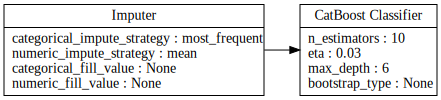

In [12]:
automl.best_pipeline.describe()
automl.best_pipeline.graph()

Let's score the model performance by evaluating predictions on the holdout set.

In [13]:
best_pipeline = automl.best_pipeline.fit(X_train, y_train)

score = best_pipeline.score(
    X=X_holdout,
    y=y_holdout,
    objectives=['f1'],
)

dict(score)

{'F1': 0.8}

From the pipeline, we can see which features are most important for predictions.

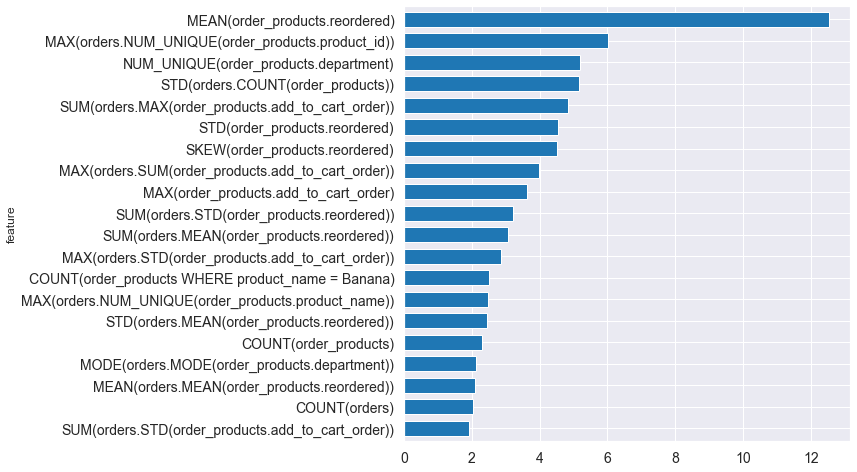

In [14]:
feature_importance = best_pipeline.feature_importance
feature_importance = feature_importance.set_index('feature')['importance']
top_k = feature_importance.abs().sort_values().tail(20).index
feature_importance[top_k].plot.barh(figsize=(8, 8), fontsize=14, width=.7);

### Making Predictions

We are ready to make predictions with our trained model. First, let's calculate the same set of features by using the feature definitions. We will use a cutoff time based on the latest information available in the dataset.

In [15]:
fm = ft.calculate_feature_matrix(
    features=fd,
    entityset=es,
    cutoff_time=ft.pd.Timestamp('2015-03-02'),
    cutoff_time_in_index=True,
    verbose=False,
)

fm.head()

,,COUNT(orders),SUM(order_products.add_to_cart_order),SUM(order_products.reordered),STD(order_products.add_to_cart_order),STD(order_products.reordered),MAX(order_products.add_to_cart_order),MAX(order_products.reordered),SKEW(order_products.add_to_cart_order),SKEW(order_products.reordered),MIN(order_products.add_to_cart_order),...,NUM_UNIQUE(orders.MODE(order_products.department)),NUM_UNIQUE(orders.MODE(order_products.product_id)),NUM_UNIQUE(orders.MODE(order_products.product_name)),MODE(orders.MODE(order_products.department)),MODE(orders.MODE(order_products.product_id)),MODE(orders.MODE(order_products.product_name)),COUNT(order_products WHERE product_name = Banana),COUNT(order_products WHERE department = produce),NUM_UNIQUE(order_products.orders.user_id),MODE(order_products.orders.user_id)
user_id,time,,,,,,,,,,,,,,,,,,,,,
50025,2015-03-02,1,15,0,1.581139,0.0,5,0,0.0,0.0,1,...,1,1,1,dairy eggs,15737,"Cheese, Pure Goat Milk, Plain Chef's Chevre",0.0,1.0,1,50025
48818,2015-03-02,1,105,0,4.183300,0.0,14,0,0.0,0.0,1,...,1,1,1,produce,5876,100% Lactose Free Fat Free Milk,0.0,5.0,1,48818
9719,2015-03-02,1,820,0,11.690452,0.0,40,0,0.0,0.0,1,...,1,1,1,dairy eggs,432,All Natural Gluten Free Teff Wraps,0.0,6.0,1,9719
19036,2015-03-02,1,120,0,4.472136,0.0,15,0,0.0,0.0,1,...,1,1,1,dairy eggs,9438,Applewood Smoked Bacon,0.0,2.0,1,19036
38423,2015-03-02,1,21,0,1.870829,0.0,6,0,0.0,0.0,1,...,1,1,1,dairy eggs,10831,Crushed Tomatoes,0.0,1.0,1,38423


Now, let's predict whether customers will purchase bananas within the next 3 days.

In [16]:
values = best_pipeline.predict(fm).values

prediction = fm[[]]
prediction['bought_product (estimate)'] = values
prediction.head()

,,bought_product (estimate)
user_id,time,
50025,2015-03-02,False
48818,2015-03-02,True
9719,2015-03-02,True
19036,2015-03-02,True
38423,2015-03-02,False


### Next Steps

At this point, we have completed the machine learning application. We can revisit each step to explore and fine-tune with different parameters until the model is ready for deployment. For more information on how to work with the features produced by Featuretools, take a look at [the Featuretools documentation](https://docs.featuretools.com/). For more information on how to work with the models produced by EvalML, take a look at [the EvalML documentation](https://evalml.alteryx.com/).